# Importing libraries and processing the data

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from power.ml_ops.cross_val import get_folds, train_test_split, get_X_y_seq
from power.ml_ops.model import init_baseline_keras, compile_model, initialize_model, train_model

# tensforflow
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import Lambda

2024-03-13 15:52:44.001827: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 15:52:44.542174: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 15:52:44.550279: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 15:52:47.761596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('../raw_data/1980-2022_pv.csv')

In [3]:
df.head(2)

,_0-1,_0,local_time,electricity,irradiance_direct,irradiance_diffuse,temperature,source
0,NaN,315532800000,1980-01-01 01:00:00+01:00,0.0,0.0,0.0,-1.296,data/pv_data/1980_pv.csv
1,NaN,315536400000,1980-01-01 02:00:00+01:00,0.0,0.0,0.0,-1.216,data/pv_data/1980_pv.csv


In [4]:
df = df.drop(columns=['irradiance_direct', 'source', '_0-1', 'temperature', 'irradiance_diffuse'])
df.electricity = df.electricity.astype(float)
df.local_time = df.local_time.apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z"))
df['_0'] = pd.to_datetime(df['_0'], unit='ms').dt.tz_localize('UTC')
df.rename(columns={'_0': 'utc_time'}, inplace=True)
df.utc_time = pd.to_datetime(df.utc_time,utc=True)

In [67]:
pv_df = df.copy()

In [68]:
min_date = '1980-01-01 00:00:00'
max_date = '2019-12-31 23:00:00'
train = pv_df[pv_df['utc_time'] <= max_date]
test = pv_df[pv_df['utc_time'] > max_date]

In [69]:
train = train[['electricity']]
test = test[['electricity']]

# Cross validation

In [70]:
TARGET = 'electricity'
fold_length = 43800             # 5 years
fold_stride = 43800             # 5 years
train_test_ratio = 0.8          # 4 yrs/5 yrs
input_length = 48               # number of obsevations per one sequence
output_length = 24              # Day-ahead predictions
n_seq_train = 1000              # number_of_sequences_train
n_seq_val = 200                 # number_of_sequences_test
n_unit = 24                     # number of hidden units
learning_rate = 0.02
patience = 5
epochs = 50
batch_size = 32

In [71]:
def cross_validate_baseline_and_lstm():

    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []

    # 0 - Creating folds
    # =========================================
    folds = get_folds(train, fold_length, fold_stride)

    for fold_id, fold in enumerate(folds):

        # 1 - Train/Test split the current fold
        # =========================================
        (fold_train, fold_val) = train_test_split(fold, train_test_ratio, input_length)

        X_train, y_train = get_X_y_seq(fold_train, n_seq_train, input_length, output_length, gap_hours=12)
        X_val, y_val = get_X_y_seq(fold_val, n_seq_val, input_length, output_length, gap_hours=12)

        # 2 - Modelling
        # =========================================

        ##### Baseline Model
        baseline_model = init_baseline_keras()
        mae_baseline = baseline_model.evaluate(X_val, y_val, verbose=0)[1]
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = initialize_model(X_train, y_train, n_unit=n_unit)
        model = compile_model(model, learning_rate=learning_rate)
        model, history = train_model(model,
                                     X_train,
                                     y_train,
                                     validation_split = 0.2,
                                     batch_size = batch_size,
                                     epochs = epochs)

        # Create a figure and axes object with 1 row and 2 columns
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

        # Plot training & validation MAE values
        axes[0].plot(history.history['mae'])
        axes[0].plot(history.history['val_mae'])
        axes[0].set_title('Model MAE')
        axes[0].set_ylabel('MAE')
        axes[0].set_xlabel('Epoch')
        axes[0].legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        axes[1].plot(history.history['loss'])
        axes[1].plot(history.history['val_loss'])
        axes[1].set_title('Model Loss')
        axes[1].set_ylabel('Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].legend(['Train', 'Validation'], loc='upper left')

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Show the plot
        plt.show()

        res = model.evaluate(X_val, y_val, verbose=0)    # evaluating LSTM (metric)
        mae_lstm = res[1]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")

        ##### Comparison LSTM vs Baseline for the current fold
        print(f"improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model


--------------------------------------------------
MAE baseline fold n°0 = 0.25


2024-03-12 16:11:00.502681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 16:11:00.506145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 16:11:00.509194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

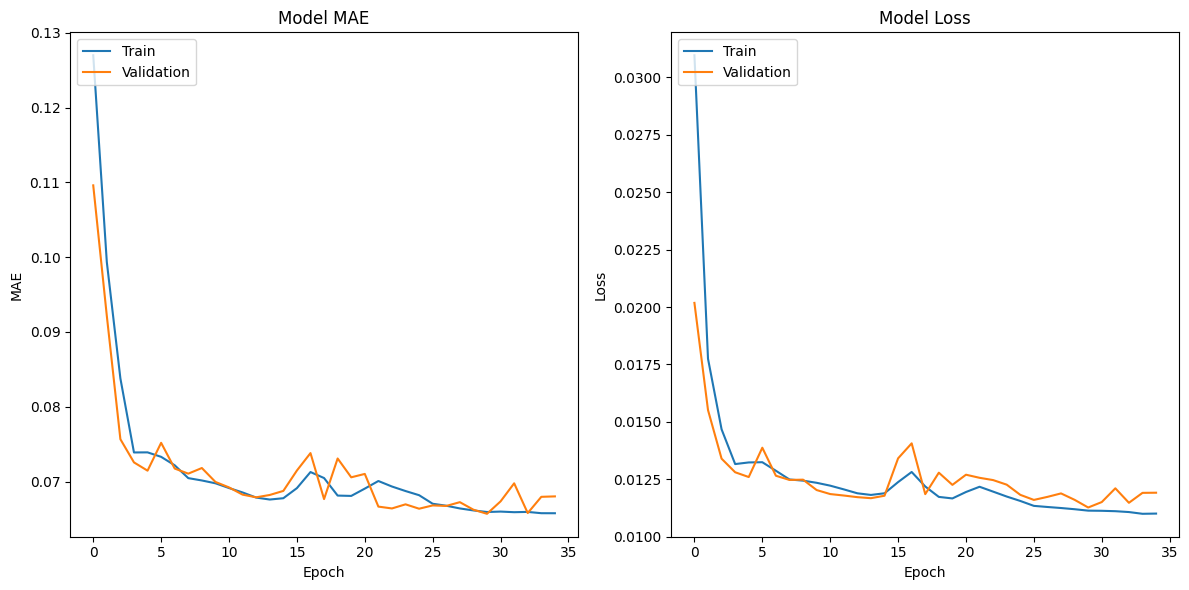

MAE LSTM fold n°0 = 0.06
improvement over baseline: 74.35 % 

--------------------------------------------------
MAE baseline fold n°1 = 0.28


2024-03-12 16:11:23.954393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 16:11:23.956752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 16:11:23.958177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

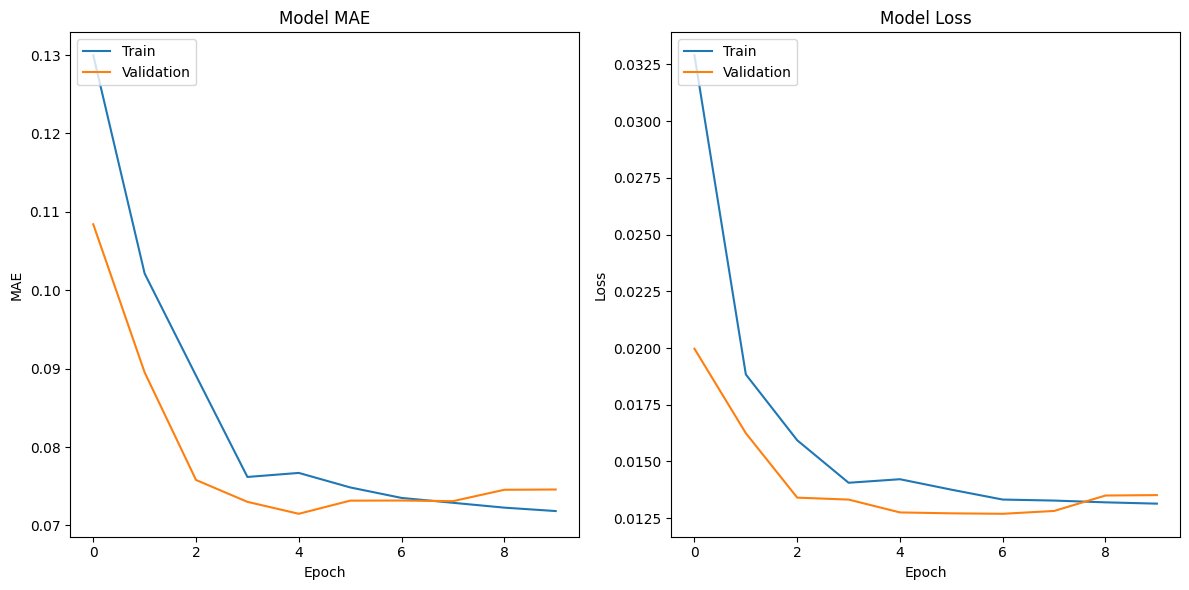

MAE LSTM fold n°1 = 0.08
improvement over baseline: 72.75 % 

--------------------------------------------------
MAE baseline fold n°2 = 0.27


2024-03-12 16:11:31.945976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 16:11:31.949346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 16:11:31.951000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

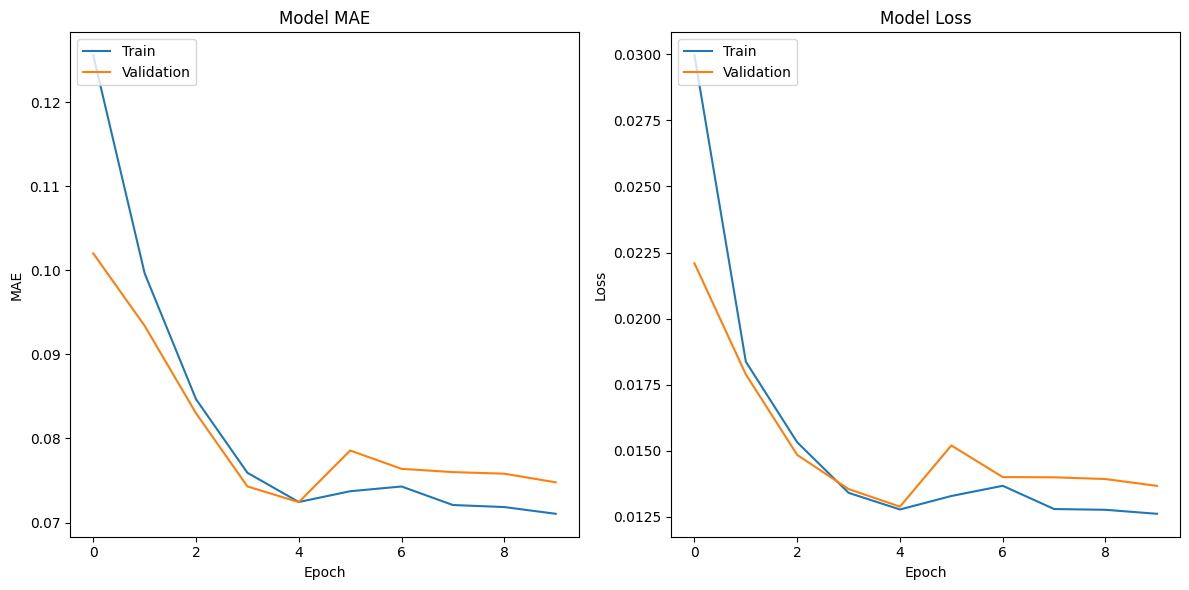

MAE LSTM fold n°2 = 0.07
improvement over baseline: 73.92 % 

--------------------------------------------------
MAE baseline fold n°3 = 0.27


2024-03-12 16:11:40.480704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 16:11:40.482970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 16:11:40.484878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

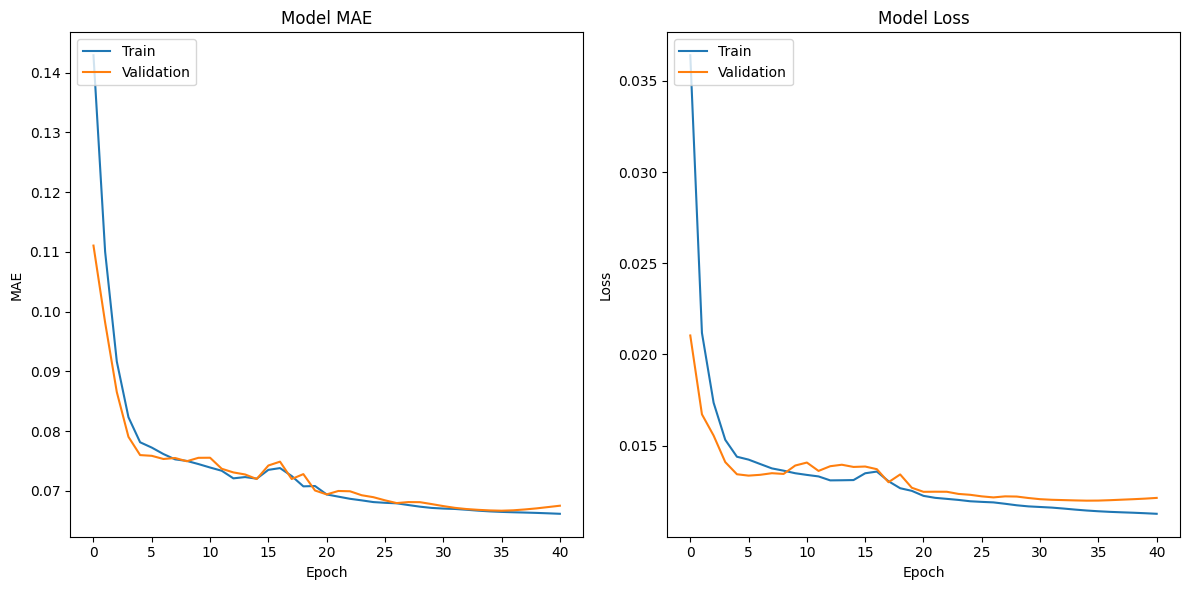

MAE LSTM fold n°3 = 0.07
improvement over baseline: 74.52 % 

--------------------------------------------------
MAE baseline fold n°4 = 0.26


2024-03-12 16:11:59.181847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 16:11:59.183884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 16:11:59.185606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

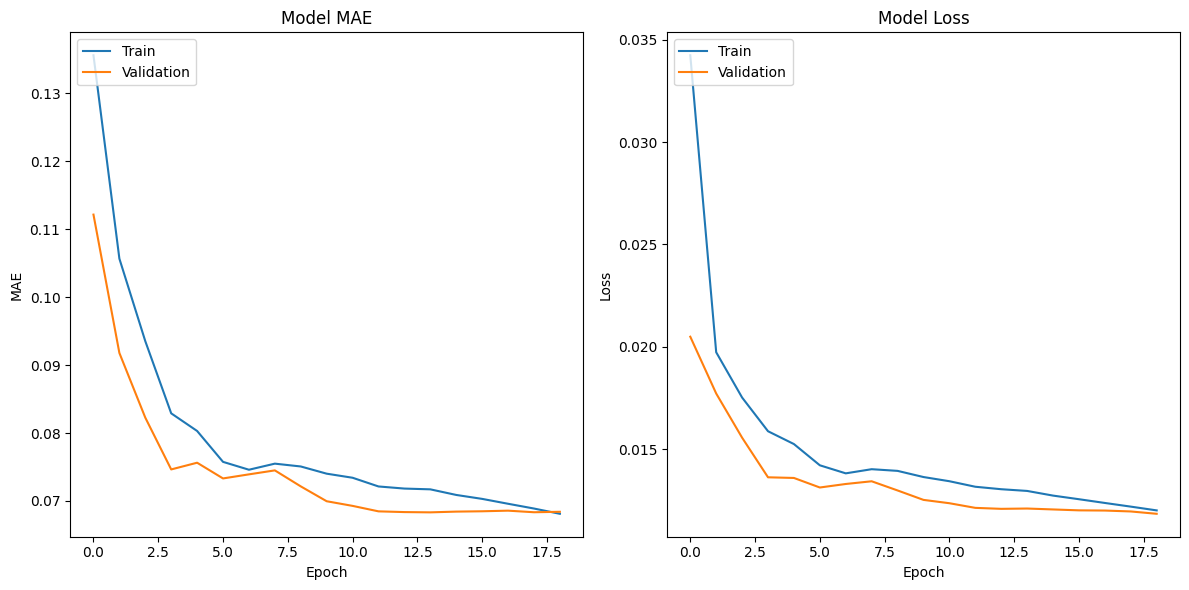

MAE LSTM fold n°4 = 0.07
improvement over baseline: 73.45 % 

--------------------------------------------------
MAE baseline fold n°5 = 0.27


2024-03-12 16:12:09.681012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 16:12:09.682839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 16:12:09.684260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

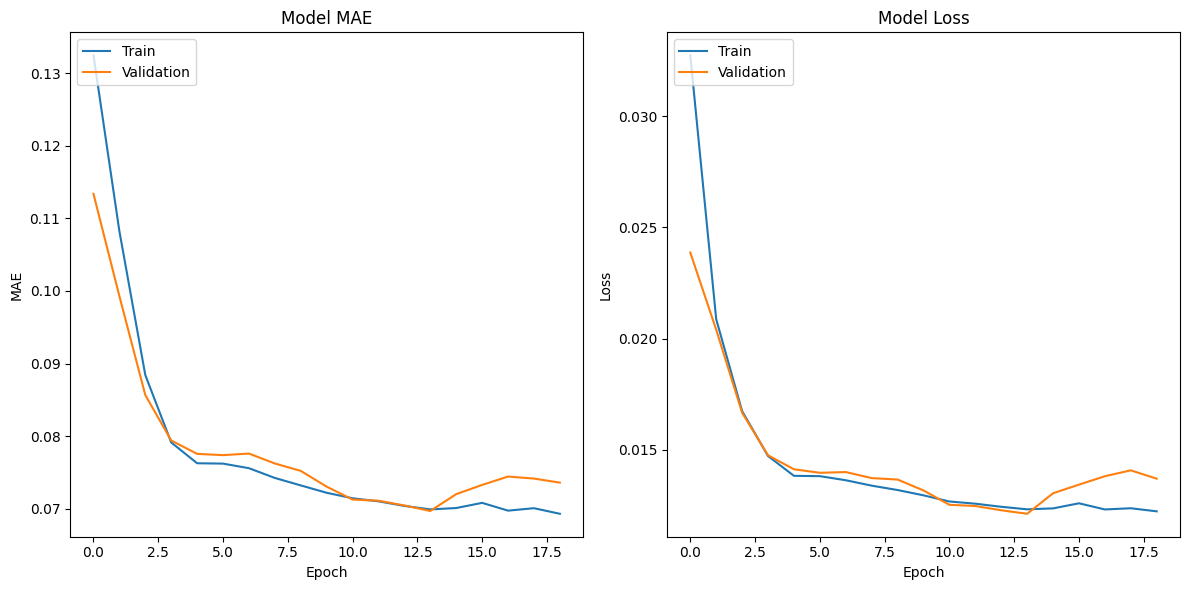

MAE LSTM fold n°5 = 0.07
improvement over baseline: 74.29 % 

--------------------------------------------------
MAE baseline fold n°6 = 0.26


2024-03-12 16:12:20.821992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 16:12:20.824170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 16:12:20.825827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

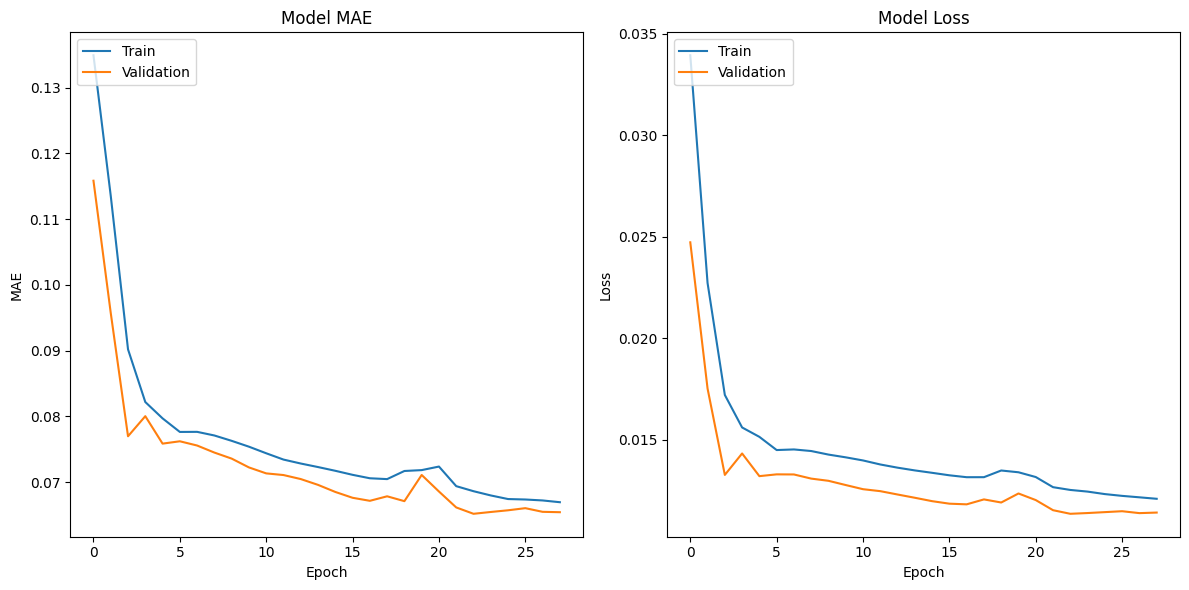

MAE LSTM fold n°6 = 0.07
improvement over baseline: 74.66 % 

--------------------------------------------------
MAE baseline fold n°7 = 0.24


2024-03-12 16:12:34.338234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 16:12:34.341235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 16:12:34.342791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

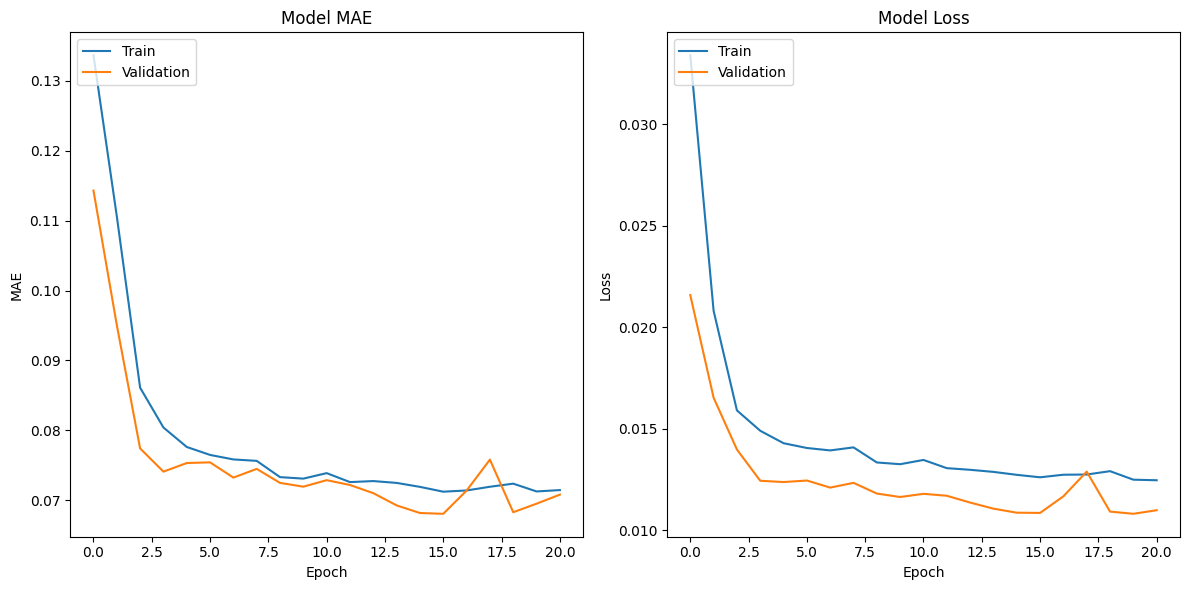

MAE LSTM fold n°7 = 0.07
improvement over baseline: 70.62 % 



In [72]:
mae_baselines, mae_lstms = cross_validate_baseline_and_lstm()

In [73]:
print(f"average percentage improvement over baseline = {round(np.mean(1 - (np.array(mae_lstms)/np.array(mae_baselines))),2)*100}%")

average percentage improvement over baseline = 74.0%


# Training the main model

In [74]:
X_train, y_train = get_X_y_seq(train, number_of_sequences=10_000, input_length=48, output_length=24, gap_hours=12)

In [75]:
model = initialize_model(X_train, y_train, n_unit=n_unit)
model = compile_model(model, learning_rate=learning_rate)
model, history = train_model(model,
                             X_train,
                             y_train,
                             validation_split = 0.1,
                             batch_size = batch_size,
                             epochs = epochs)

2024-03-12 16:15:12.858446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 16:15:12.861768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 16:15:12.863293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

# Prediction

In [76]:
test = df[df['utc_time'] > max_date]

In [96]:
input_pred = '2021-07-28 12:00:00'
X_pred = test[test['utc_time'] < input_pred][-48:]

In [97]:
X_pred = X_pred[['electricity']]

In [98]:
import tensorflow as tf

X_pred = X_pred.to_numpy()
X_pred_tf = tf.convert_to_tensor(X_pred)
X_pred_tf = tf.expand_dims(X_pred_tf, axis=0)

In [99]:
y_pred = model.predict(X_pred_tf)

1/1 [==============================] - 0s 42ms/step


In [100]:
y_pred[0]

array([-0.00658569,  0.00133881,  0.01269624,  0.03496667,  0.07067794,
        0.13678557,  0.23756112,  0.36698225,  0.48050722,  0.55649096,
        0.58289564,  0.5655865 ,  0.51688933,  0.44745415,  0.34097916,
        0.22374192,  0.11531967,  0.04541521,  0.01682754,  0.00785562,
        0.00589593,  0.00524443,  0.01001667,  0.01805037], dtype=float32)

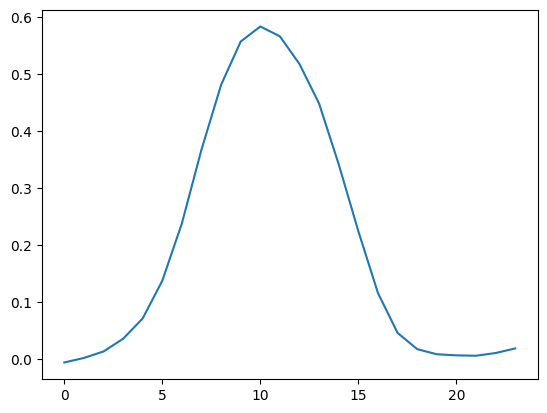

In [101]:
plt.plot(y_pred[0])

In [102]:
y_true = test[test['utc_time'] >= input_pred][12:36]
y_true = y_true[['electricity']]
y_true = y_true.to_numpy()
y_true = y_true.reshape(1,24)[0]
y_true

array([0.   , 0.   , 0.   , 0.002, 0.037, 0.097, 0.272, 0.416, 0.448,
       0.531, 0.614, 0.515, 0.515, 0.513, 0.344, 0.232, 0.135, 0.049,
       0.006, 0.   , 0.   , 0.   , 0.   , 0.   ])

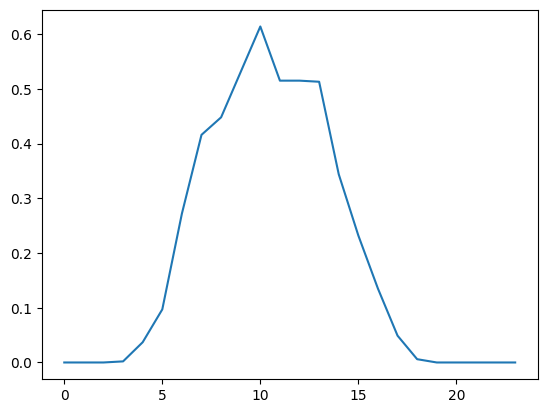

In [103]:
plt.plot(y_true)

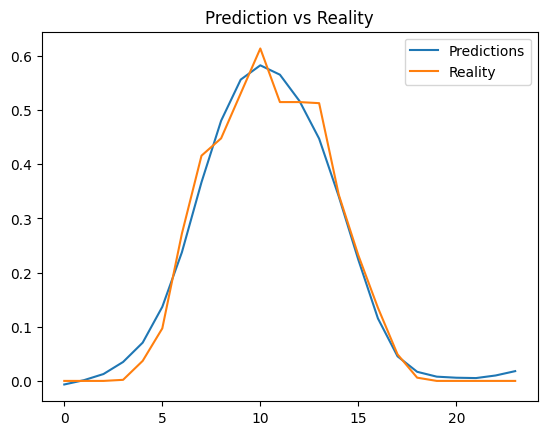

In [104]:
plt.plot(y_pred[0], label='Predictions')
plt.plot(y_true, label='Reality')

plt.title('Prediction vs Reality')
plt.legend()

# Show the plot
plt.show()